In [1]:
import networkx as nx
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

DG = nx.DiGraph()
edges = [('o','a'),('o','b'),('a','b'),('a','d'),('b','d')]
C = [3,2,2,3,2]

edge_labels={}
for e,c in zip(edges, C):
    DG.add_edge(e[0],e[1],capacity=c)
    edge_labels[e] = str(c)

def draw_labels(d=None):
    if d == None:
        d = edge_labels
    else:
        d = d.copy()
        for k,v in edge_labels.items():
            print(k,v)
            d[k] = str(d.get(k,0) + int(v))
    nx.draw_networkx_edge_labels(
        DG,
        pos,
        edge_labels=d,
        font_color='blue',
    )

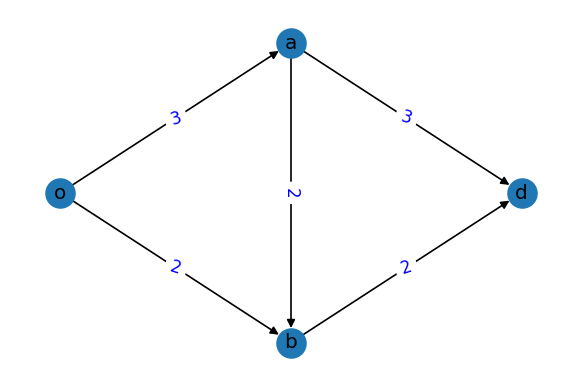

In [2]:
pos = {
    'o':[0,-1],
    'a':[2,0],
    'b':[2,-2],
    'd':[4,-1]
}
plt.figure(dpi=120)
draw_labels()
nx.draw(DG, pos, with_labels=True)
plt.savefig('fig/graph.png')

A total capacity of 5 should be removed to avoid unitary flows from o to d


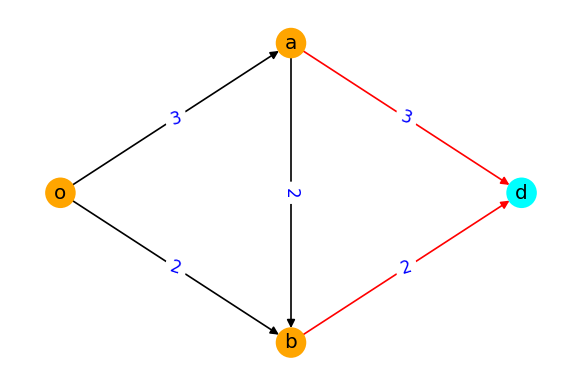

In [3]:
mincut = nx.algorithms.flow.minimum_cut(DG, 'o','d')
print(f"A total capacity of {mincut[0]} should be removed to avoid unitary flows from o to d")

node_color = ['orange' if u in mincut[1][0] else 'cyan' for u in DG.nodes]
edge_color = ['red' if u in mincut[1][0] and v in mincut[1][1] else 'black' for u,v in DG.edges]

plt.figure(dpi=120)
draw_labels()
nx.draw(DG, pos, with_labels=True, node_color=node_color, edge_color=edge_color)
plt.savefig('fig/min_cut.png')

In [4]:
# powerset sorted by subset size
def subpowerset(iterable, max_size=None):
    s = list(iterable)
    if max_size == None or max_size > len(s):
        max_size = len(s)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(max_size+1))

In [5]:
def all_cuts(DG, origin, destination):
    # dictionary with cut as key and cut capacity as value
    # the cut is represented with a tuple of the nodes in the same subset of the origin (with the origin)
    # only meaningful cuts are stored, that are the ones where the origin can reach all nodes in its subgraph and the destination is reachable by all nodes in its subgraph
    cuts = {}
    # dictionary with edge as key and list of the cuts covered by that edge as value
    # incrementing the capacity of e will increment the cut capacity of all the cuts in cuts_by_edge[e]
    cuts_by_edge = {e:set(()) for e in DG.edges}
    # dictionary with cut as key and list of edges from the subset of origin to the one of destination on that cut as value
    edges_by_cut = {}
    # exploring cuts
    for UU in subpowerset(set(DG.nodes()).difference((origin,destination))):
        U = set((origin)).union(UU)
        tu = tuple(U)
        edges_by_cut[tu] = set(())
        # updating dictionaries
        for u in U:
            for v in DG[u]:
                if v not in U:
                    cuts_by_edge[(u,v)].add(tu)
                    edges_by_cut[tu].add((u,v))
                    cuts[tu] = cuts.get(tu,0) + DG[u][v]['capacity']
    return cuts, cuts_by_edge, edges_by_cut

In [6]:
def optimal_assignment(DG, origin, destination, budget=None, cuts=None, cuts_by_edge=None):
    # the following two variables are described in all_cuts function
    if cuts == None or cuts_by_edge == None:
        cuts, cuts_by_edge = all_cuts(DG, origin, destination)
    if budget == None:
        budget = len(DG.edges)
    # dictionary with edges with improved capacity as key and capacity increment as value
    improvements = {}
    # min-cut capacity
    mincutc = min(cuts.values())
    old_mincutc = mincutc
    while budget>0:
        # set of cuts with minimum capacity
        min_cut_set = set(()).union(s for s,v in cuts.items() if v == mincutc)
        # we will consider only min-cuts to choose the edges
        edge_min_cut_cover = {e:s.intersection(min_cut_set) for e,s in cuts_by_edge.items()}
        # solve set cover problem (find smallest set of edges that cover all cuts in min_cut_set, or the maximum number with the given budget)
        covered = set(())
        edges = ()
        for ee in subpowerset(cuts_by_edge.keys(), budget):
            # union of sets of cuts covered by edges in ee
            covered_t = set(()).union(*[edge_min_cut_cover[e] for e in ee])
            # test if it is the biggest found
            if len(covered_t) > len(covered):
                covered = covered_t
                edges = ee
                # test if all minimum-cuts are covered
                if len(covered) == len(min_cut_set):
                    break
        # compute new cut capacities
        covered = covered.union(*[cuts_by_edge[e] for e in edges])
        cuts = {k:v+1 if k in covered else v for k,v in cuts.items()}
        for e in edges:
            improvements[e] = 1 + improvements.get(e,0)
        budget -= len(edges)
        mincutc = min(cuts.values())
    return old_mincutc, mincutc, improvements, cuts

In [7]:
origin = 'o'
destination = 'd'

# budgets = [1,2,4]

cuts, cuts_by_edge, edges_by_cut = all_cuts(DG, origin=origin, destination=destination)

budget = 1
old_mincutc, mincutc, improvements, new_cuts = optimal_assignment(DG, origin, destination, budget, cuts, cuts_by_edge)
print(f"With an additional budget of {budget} unit of capacity we can{' not' if old_mincutc == mincutc else ''} improve the min-cut capacity from {old_mincutc}{f' to {mincutc}' if old_mincutc != mincutc else ''},")
print("incrementing the capacities of:")
for e,c in improvements.items():
    print(f"{e} by {c} unit{'s' if c != 1 else ''}")

With an additional budget of 1 unit of capacity we can not improve the min-cut capacity from 5,
incrementing the capacities of:
('o', 'a') by 1 unit


In [8]:
# function to draw maximum flow with edge capacities improved, as indicated by improvements
def draw_labels_flow(filename, improvements=None):
    NDG = DG.copy()
    if improvements == None:
        d = edge_labels.copy()
    else:
        d = improvements.copy()
        for (u,v),c in improvements.items():
            NDG[u][v]['capacity'] += c
        for k,v in edge_labels.items():
            d[k] = str(d.get(k,0) + int(v))
    
    maxflow = nx.algorithms.flow.maximum_flow(NDG, origin, destination)
    f = maxflow[1]
    # maximum of the flow over any edge
    mfe = max([c for u,v in f.items() for c in v.values()])
    
    for k,v in edge_labels.items():
        d[k] = f"{f[k[0]][k[1]]}/{d[k]}"
    plt.figure(dpi=120)
    nx.draw_networkx_edge_labels(
        DG,
        pos,
        edge_labels=d,
        font_color='blue',
    )
    edge_color = [[f[u][v]/mfe,0,0] for u,v in NDG.edges]
    nx.draw(NDG, pos, with_labels=True, edge_color=edge_color)
    plt.savefig(f"fig/{filename}")

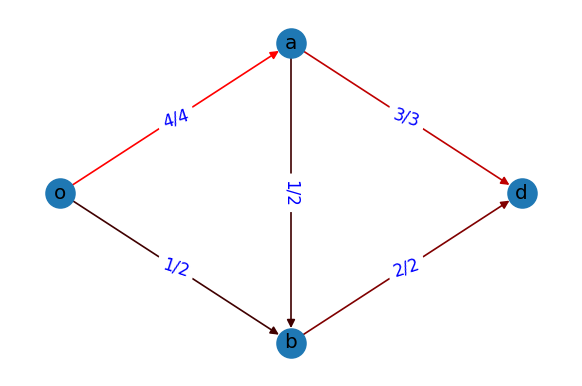

In [9]:
draw_labels_flow('max_flow_1.png', improvements)

In [10]:
def count(item):
    d = {}
    for i in item:
        d[i] = 1 + d.get(i,0)
    return d

In [11]:
def all_assignments(DG, origin, destination, budget, cuts=None, cuts_by_edge=None, edges_by_cut=None):
    # the following two variables are described in all_cuts function
    if None in [cuts, cuts_by_edge, edges_by_cut]:
        cuts, cuts_by_edge, edges_by_cut = all_cuts(DG, origin, destination)
    old_mincutc = min(cuts.values())
    new_mincutc = -1
    # list of best assignments
    selections = []
    # for every possible assignments of budget units of capacity among edges
    for sel in itertools.combinations_with_replacement(DG.edges, r=budget):
        mincutc = float('inf')
        # dictionary with edge as key and new units assigned to that edge as value 
        counts = count(sel)
        # compute min-cut capacity for the assignment
        for cut,edges in edges_by_cut.items():
            t = cuts[cut]
            # sum old cut capacity with the units assigned to edges on that cut
            for e in edges:
                t += counts.get(e,0)
            if mincutc > t:
                mincutc = t
        # save new min-cut capacity and related assignments
        if new_mincutc < mincutc:
            new_mincutc = mincutc
            selections = [counts]
        elif new_mincutc == mincutc:
            selections.append(counts)
    # find one assignment that maximizes the sum of the capacities of all the cuts
    sel = ()
    sel_gain = 0
    for sel_t in selections:
        # this sum equals the previous sum + the gain of the new assignment, i.e. the sum of the number of cuts covered by every edge
        sel_gain_t = sum([len(cuts_by_edge[e])*r for e,r in sel_t.items()])
        if sel_gain < sel_gain_t:
            sel = sel_t
            sel_gain = sel_gain_t
    return old_mincutc, new_mincutc, selections, sel, sel_gain

With an additional budget of 2 units of capacity we can not improve the min-cut capacity from 5.
The possible choices are:
[{('a', 'd'): 1, ('o', 'a'): 1},
 {('b', 'd'): 1, ('o', 'a'): 1},
 {('b', 'd'): 1, ('o', 'b'): 1}]
One of the choices that maximize the sum of the capacities of the cuts is
{('o', 'a'): 1, ('a', 'd'): 1}
with a total increment of 4 units of capacity (summing the capacities of every cut).

With an additional budget of 4 units of capacity we can not improve the min-cut capacity from 5.
The possible choices are:
[{('a', 'd'): 2, ('o', 'a'): 2},
 {('a', 'd'): 1, ('b', 'd'): 1, ('o', 'a'): 2},
 {('b', 'd'): 2, ('o', 'a'): 2},
 {('a', 'd'): 1, ('b', 'd'): 1, ('o', 'a'): 1, ('o', 'b'): 1},
 {('b', 'd'): 2, ('o', 'a'): 1, ('o', 'b'): 1},
 {('b', 'd'): 2, ('o', 'b'): 2}]
One of the choices that maximize the sum of the capacities of the cuts is
{('o', 'a'): 2, ('a', 'd'): 2}
with a total increment of 8 units of capacity (summing the capacities of every cut).



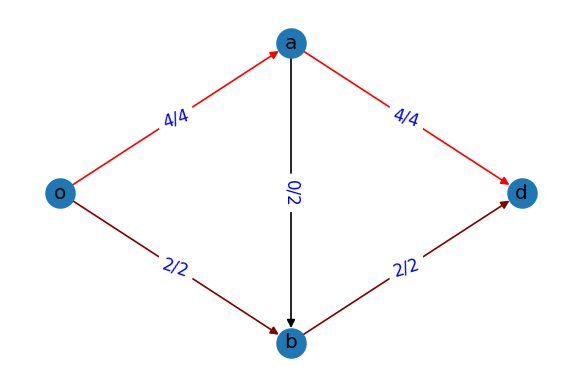

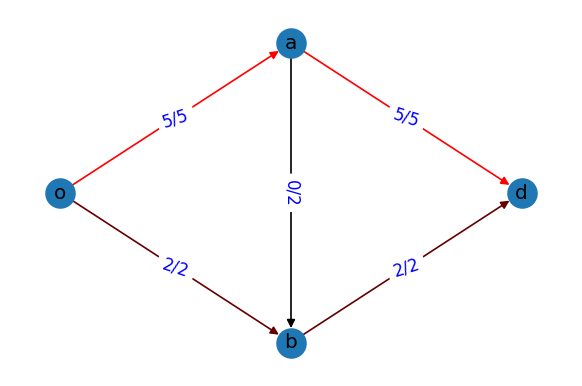

In [12]:
# origin = 'o'
# destination = 'd'

budgets = [2,4]

cuts, cuts_by_edge, edges_by_cut = all_cuts(DG, origin=origin, destination=destination)

for budget in budgets:
    old_mincutc, new_mincutc, selections, sel, sel_gain = all_assignments(DG, origin, destination, budget, cuts, cuts_by_edge, edges_by_cut)
    print(f"With an additional budget of {budget} unit{'' if budget == 1 else 's'} of capacity we can{' not' if old_mincutc == mincutc else ''} improve the min-cut capacity from {old_mincutc}{f' to {mincutc}' if old_mincutc != mincutc else ''}.")
    print(f"The possible choices are:")
    pprint(selections)
    print(f"One of the choices that maximize the sum of the capacities of the cuts is\n{sel}\nwith a total increment of {sel_gain} units of capacity (summing the capacities of every cut).\n")
    draw_labels_flow(f"max_flow_{budget}.png", sel)